### 에일리언 생성

In [96]:
# install pytorch
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [97]:
import os
import torch
import matplotlib.pyplot as plt

#
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

import sys
import os
## 절대경로
sys.path.append(os.path.abspath(''))

In [98]:
## 선언된 함수 import
from plot_image_grid import image_grid

In [99]:
## 딥러닝 디바이스 생성
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

## 파일 가져오기
path = os.path.join("./data", "cow_mesh/cow.obj")
mesh = load_objs_as_meshes([ path ], device=device)

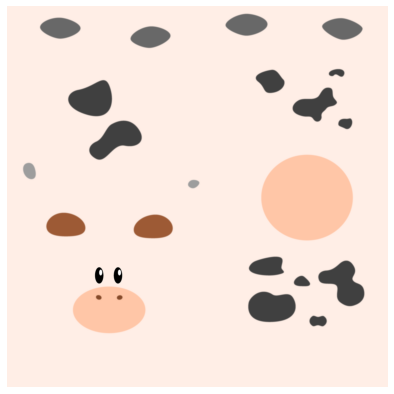

In [100]:
plt.figure(figsize=(7, 7))
texture_image = mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

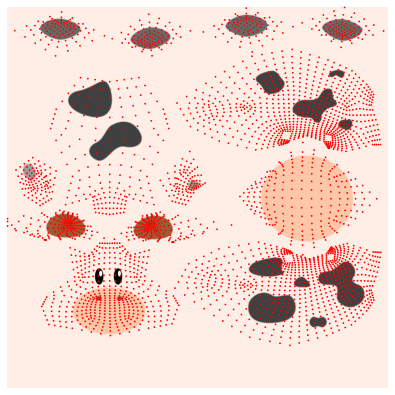

In [101]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off");

In [102]:
## 카메라 시점 설정
R, T = look_at_view_transform(2.1, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [103]:
##
raster_settings = RasterizationSettings(
    image_size = 1024, # 사진의 픽셀 단위 사이즈
    blur_radius = 0.0, # 0 ~ 2 사이의 면적 확장 거리
    faces_per_pixel = 1, # 픽셀 당 추적하는 면적의 수로 z축을 따라 가장 가까운 면을 반환
)

light = PointLights(
    device = device, # 장치 설정
    location = [ [0.0, 0.0, -3.0] ] # 빛의 x, y ,z 위치
)

renderer = MeshRenderer(

    rasterizer = MeshRasterizer( # 레스라이저: 3D 그래픽을 표시하기 위해 벡터 정보를 레스터 이미지로 변환
        cameras = cameras,
        raster_settings = raster_settings
    ),

    shader = SoftPhongShader( # 3D 컴퓨터 그래픽에서 최종적으로 화면에 출력하는 픽셀의 색을 정함
        device = device,
        cameras = cameras,
        lights = light
    )
)

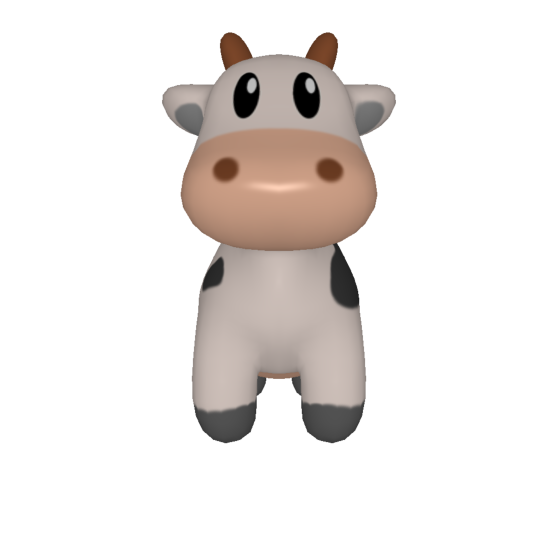

In [104]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [104]:
R, T = look_at_view_transform(
    dist=2.7, # dist: distance of the camera from the object
    elev=10,  # elev: angle in degrees or radians. This is the angle between the vector from the object to the camera
    azim=-150 # azim: angle in degrees or radians. The vector from the object to the camera is projected onto a horizontal plane y = 0.
)

cameras = FoVPerspectiveCameras(
    device=device,
    R=R, # R: Rotation matrix of shape (N, 3, 3)
    T=T  # T: Translation matrix of shape (N, 3)
)

light.location = torch.tensor(
    [ [2.0, 2.0, 2.0] ],
    device=device
)

materials = Materials(
    device=device,
    specular_color=[ [1.0, 1.0, 1.0] ], # specular_color: specular reflectivity of the material
    shininess=10.0 # shininess: The specular exponent for the material.
)
